In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
from scipy import optimize
from scipy import *
import scipy
from scipy import stats
import tables
import h5py
import ODE_utils as odeu

#!jt -t onedork -cellw 90%

In [2]:
uscal=25
vscal=5
extraterms=True

In [3]:
rnputil=np.load('rnputil.npy')
urange=np.load('urange.npy')[::uscal]
vrange=np.load('vrange.npy')[::vscal]

In [4]:
with h5py.File('rnp.h5','r') as f:
    r_group_key = list(f.keys())[0]
    rnpi=f[r_group_key]
    rnp = np.asarray(rnpi[::uscal,::vscal],dtype=np.float_)    
with h5py.File('signp.h5','r') as f:
    sig_group_key = list(f.keys())[0]
    signpi=f[sig_group_key]
    signp = np.asarray(signpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('phinp.h5','r') as f:
    phi_group_key = list(f.keys())[0]
    phinpi=f[phi_group_key]
    phinp = np.asarray(phinpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('massnp.h5','r') as f:
    mass_group_key = list(f.keys())[0]
    massnpi=f[mass_group_key]
    massnp = np.asarray(massnpi[::uscal,::vscal])
    
    
if extraterms==True:
    with h5py.File('drnpu.h5','r') as f:
        dru_group_key = list(f.keys())[0]
        drnpui=f[dru_group_key]
        drnpu = np.asarray(drnpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('drnpv.h5','r') as f:
        drv_group_key = list(f.keys())[0]
        drnpvi=f[drv_group_key]
        drnpv = np.asarray(drnpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dsignpu.h5','r') as f:
        dsigu_group_key = list(f.keys())[0]
        dsignpui=f[dsigu_group_key]
        dsignpu = np.asarray(dsignpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dsignpv.h5','r') as f:
        dsigv_group_key = list(f.keys())[0]
        dsignpvi=f[dsigv_group_key]
        dsignpv = np.asarray(dsignpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dphinpu.h5','r') as f:
        dphiu_group_key = list(f.keys())[0]
        dphinpui=f[dphiu_group_key]
        dphinpu = np.asarray(dphinpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dphinpv.h5','r') as f:
        dphiv_group_key = list(f.keys())[0]
        dphinpvi=f[dphiv_group_key]
        dphinpv = np.asarray(dphinpvi[::uscal,::vscal],dtype=np.float_)
    
    

print(str(rnp.nbytes)+" bytes")

print(rnp)

switchax=rnputil[9]
print(switchax)
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    #phinp=np.swapaxes(phinp,0,1)
    #massnp=np.swapaxes(massnp,0,1)
    print("Switched Axes")

#print(massnp[1])
print(rnp[:,4])

112000 bytes
[[ 5.          5.02766042  5.05536431 ... 14.66748046 14.67499982
  14.68248575]
 [ 3.61808333  3.64176307  3.6655486  ... 14.21454893 14.22404134
  14.23349323]
 [ 2.25159591  2.26531451  2.2791844  ... 13.41251632 13.42530354
  13.43804025]
 ...
 [ 0.61341444  0.61985038  0.62556402 ...  0.6862419   0.68624116
   0.68624043]
 [ 0.32459131  0.42525398  0.47519708 ...  0.6862419   0.68624116
   0.68624043]
 [ 0.16271089  0.39359274  0.45693672 ...  0.6862419   0.68624116
   0.68624043]]
0.0
[5.11089821 3.71343228 2.3073791  1.56290464 1.37849549 1.33905562
 1.33070272 1.32886001 1.3283816  1.3282669  1.3281238  1.32789005
 1.32749765 1.32683643 1.32572159 1.32384176 1.32067196 1.31532719
 1.30631646 1.29113079 1.26556063 1.22259714 1.15082854 1.03303752
 0.85133758 0.63524033 0.53256568 0.52304732]


In [5]:
print(rnputil)

M=massnp[1,-1]
print(M,massnp[1,-1])

N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0
else:
    du0=1/N
    dv0=du0
    
#M=nan.max(massnp)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.7,1.31,50.0],args=(M,Q,Lambda), method='hybr',tol=.0000001)
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]
print('---')
print(M,Q,Lambda)
print('---')
print(0.0,rminus,rplus,rcosm)


['1737500' '695' '2500' '5.0' '0.2763833333333333' '1.0' '0.95' '0.01'
 'True' '0.0' 'edd']
1.0000005153870593 1.0000005153870593
N=1737500
---
1.0000005153870593 0.95 0.01
---
0.0 0.6865652448848756 1.32845552170681 16.251308807870082


In [6]:
def kappa(fr,r,M,Q,Lambda):
    return 0.5*np.abs(scipy.misc.derivative(fr,r,dx=.00000001,n=1,args=(M,Q,Lambda)))
#def kappa2(dfr,r,M,Q,Lambda):
    #return optimize.root(dfr,[0.01,1.5,50.0],args=(M,Q,Lambda),tol=10**(-10), method='hybr')

kappaplus=kappa(fr,rplus,M,Q,Lambda)
kappaminus=kappa(fr,rminus,M,Q,Lambda)
kappacosm=kappa(fr,rcosm,M,Q,Lambda)
print('k+: '+str(kappaplus),'k-: '+str(kappaminus),'kc: '+str(kappacosm))
###double-check for Lambda=0
###kappaminus
#print(np.abs((M*rminus-Q**2)/rminus**3.0))
#print(0.5*np.abs(dfr(rminus,M,Q,Lambda)))
###

#print(kappaplus-kappacosm)


k+: 0.17725882758140576 k-: 0.6695198210670671 kc: 0.05059493102255175


In [7]:
uval=25#334#2100
print(0,Nu)

0 28


In [8]:
dercorr=dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)
vrange2=vrange*dercorr
print(dercorr)

1.0


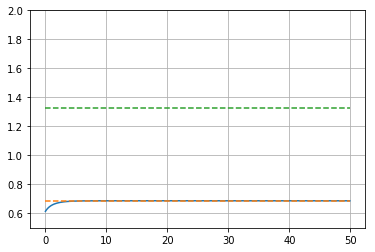

In [9]:
plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
#plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')
#plt.ylim(rcosm-.0000001,rcosm+.0000001)
#plt.ylim(rminus-.001,rminus+.001)
plt.ylim(0.5,2.0)
#plt.yscale('log')
plt.grid()
plt.show()

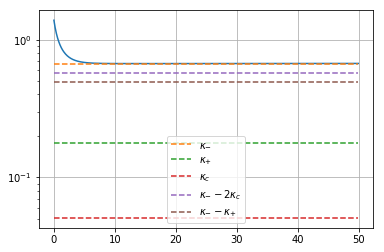

In [10]:
plt.plot(vrange2,np.abs(dsignpv[uval])/dercorr)
#plt.plot(vrange2,np.abs(dsignpu[uval])/dercorr)
plt.plot([min(vrange2),max(vrange2)],[kappaminus,kappaminus],'--',label=r'$\kappa_{-}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappacosm,kappaminus-kappacosm],'--',label=r'$\kappa_{-}-\kappa_{c}$')
#plt.plot([min(vrange),max(vrange)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
plt.plot([min(vrange2),max(vrange2)],[kappaplus,kappaplus],'--',label=r'$\kappa_{+}$')
plt.plot([min(vrange2),max(vrange2)],[kappacosm,kappacosm],'--',label=r'$\kappa_{c}$')
plt.plot([min(vrange2),max(vrange2)],[kappaminus-2*kappacosm,kappaminus-2*kappacosm],'--',label=r'$\kappa_{-}-2\kappa_{c}$')
plt.plot([min(vrange2),max(vrange2)],[kappaminus-kappaplus,kappaminus-kappaplus],'--',label=r'$\kappa_{-}-\kappa_{+}$')
#plt.plot([min(vrange),max(vrange)],[kappaplus-kappacosm,kappaplus-kappacosm],'--',label=r'$\kappa_{c}$')
plt.yscale('log')
#plt.ylim(1,2)
#plt.ylim(.1,2.)
plt.legend(loc='best')
plt.grid()
plt.show()

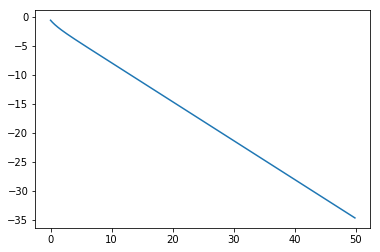

28 500
0.0 [-0.67031573 -1.21137058]
-0.6706080146423727


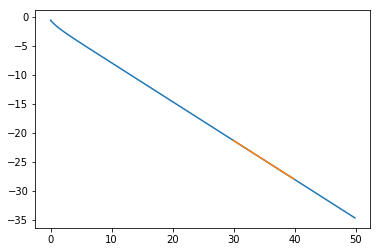

0.6703154175244646
0.0 0.05059493102255175 0.6695198210670671 0.17725882758140576
0.0 0.6189248900445153
0.0 0.4922609934856613


In [11]:
plt.plot(vrange2,signp[uval])
plt.show()
print(Nu,Nv)
vrange2=vrange*dr0v/0.5/np.abs(1-2*massnp[0][0]/rnp[0][0]+Q**2/rnp[0][0]**2-Lambda*(rnp[0][0])**2.0/3.0)
v1=Nv-200
v2=Nv-100
print(0.0,np.polyfit(vrange2[v1:v2],signp[uval][v1:v2],1.0))
print(dsignpv[uval][v2])

plt.plot(vrange2,signp[uval])
plt.plot(vrange2[v1:v2],signp[uval][v1:v2])
plt.show()

print(np.abs(dsignpv[uval][int((v1+v2)/2)]))
print(0.0,kappacosm,kappaminus,kappaplus)
print(0.0,kappaminus-kappacosm)
print(0.0,kappaminus-kappaplus)

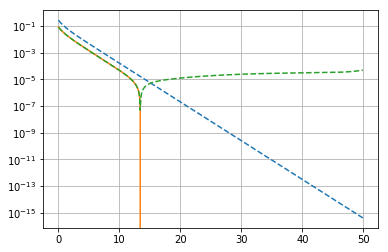

0 -4.9614400567911776e-05


In [12]:
plt.plot(vrange2,np.abs(drnpu[uval])/dercorr,'--')
plt.plot(vrange2,drnpv[uval]/dercorr)
plt.plot(vrange2,np.abs(drnpv[uval])/dercorr,'--')
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.grid()
plt.show()

print(0,nanmin(drnpv[uval]))

500
0.0 [ 0.02235909 -3.70984334]


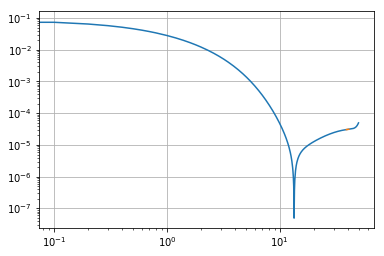

/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


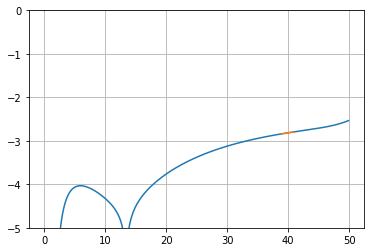

0.0 0.05059493102255175 0.17725882758140576 0.6695198210670671
0.4922609934856613
0.6189248900445153


In [13]:
v1=Nv-110
v2=Nv-90
print(Nv)
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]/dercorr))/np.log(vrange2[v1:v2]),1.0))
plt.plot(vrange2,np.abs(drnpv[uval]/dercorr))
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.plot(vrange2[v1:v2],np.abs(drnpv[uval][v1:v2]/dercorr))
#plt.plot(vrange2[v1:v2-1],np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),'-.')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

#print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2]/dercorr))/np.log(vrange2[v1:v2]),1.0))
#plt.plot(vrange2,vrange2*np.abs((1/rnp[uval]*(drnpv[uval]*dsignpu[uval]+drnpu[uval]*dsignpv[uval]))/np.abs(drnpv[uval]))/dercorr)
#plt.plot(vrange2[0:Nv-1],np.log(np.abs(np.diff(rnp[uval])/np.diff(vrange2))),'-.')
plt.plot(vrange2,np.log(np.abs(drnpv[uval])/dercorr)/np.log(vrange2))
plt.plot(vrange2[v1:v2],np.log(np.abs(drnpv[uval][v1:v2])/dercorr)/np.log(vrange2[v1:v2]))
#plt.plot(vrange2[v1:v2-1],np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),'-.')
#plt.yscale('log')
#plt.xlim(v1,v2)
#plt.xscale('log')
plt.ylim(-5,0)
plt.grid()
plt.show()



#print(0.0,np.polyfit(np.log(vrange2[v1:v2-1]),np.log(np.abs(np.diff(rnp[uval][v1:v2])/np.diff(vrange2[v1:v2]))),1.0))
print(0.0,kappacosm,kappaplus,kappaminus)
print(kappaminus-kappaplus)
print(kappaminus-kappacosm)

0.0 28


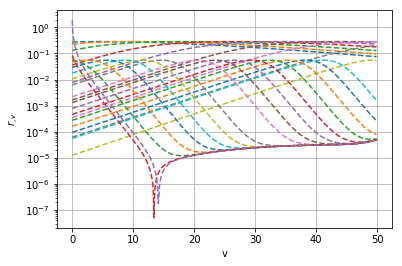

0.0 28


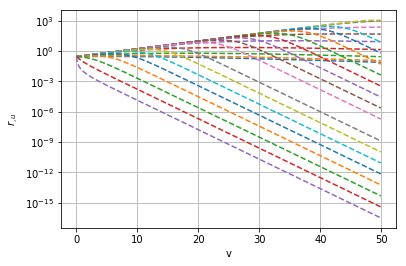

In [14]:
print(0.0,Nu)
numlines=25
for i in range(numlines):
    i=int(i*Nu/numlines)
    
    plt.plot(vrange2,np.abs(drnpv[i])/dercorr,'--')
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.xlabel('v')
plt.ylabel(r'$r_{,v}$')
plt.yscale('log')
#plt.xlim(0,10)
plt.grid()
#plt.savefig('num-rel-pics/drdv_vs_v.png',dpi=300)
plt.show()

print(0.0,Nu)
numlines=25
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(drnpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.xlabel('v')
plt.ylabel(r'$r_{,u}$')
#plt.xlim(0,6)
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/drdu_vs_v.png',dpi=300)
plt.show()

In [15]:
v1=Nv-1000
v2=Nv-300
print(vrange2[v1],vrange2[v2])
print(0.0,np.polyfit(np.log(vrange2[v1:v2]),np.log(np.abs(phinp[uval][v1:v2])),1.0))
plt.plot(vrange2,np.abs(phinp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(phinp[uval][v1:v2])/dercorr)
plt.xlim(1,vrange2[-1])
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
plt.xscale('log')
#plt.legend(loc='best')
plt.grid()
plt.title('Phi along Event Horizon')
#plt.savefig('num-rel-pics/Phi vs v_bug_fixed.png',dpi=300)
plt.show()

plt.plot(vrange2,-vrange2*dphinpv[uval]/phinp[uval]/dercorr)
plt.plot(vrange2[v1:v2],-vrange2[v1:v2]*dphinpv[uval][v1:v2]/phinp[uval][v1:v2]/dercorr)
plt.ylim(1.0,5.0)
#plt.xscale('log')
plt.ylabel(r'$-v \Phi_{,v} /\Phi$')
plt.xlabel(r'$v$')
plt.xlim(1,vrange2[-1])
plt.grid()
#plt.savefig('num-rel-pics/Power of Phi vs v_bug_fixed.png',dpi=300)
plt.show()

numlines=25
for i in range(numlines):
    i=int(i*Nu/numlines)
    plt.plot(vrange2,-vrange2*dphinpv[i]/phinp[i]/dercorr)
    plt.ylim(1.0,5.0)
#plt.xscale('log')
plt.grid()
plt.ylabel(r'$-v \Phi_{,v} /\Phi$')
plt.xlabel('v')
#plt.savefig('num-rel-pics/Powers of Phi vs v_bug_fixed.png',dpi=300)
plt.show()

print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval][v1:v2])),1.0))
plt.plot(vrange2,np.abs(massnp[uval])/dercorr)
plt.plot(vrange2[v1:v2],np.abs(massnp[uval][v1:v2])/dercorr)
plt.xlim(1,vrange[-1])
plt.yscale('log')
plt.xlabel('v')
plt.xscale('log')
#plt.legend(loc='best')
plt.grid()
#plt.savefig('num-rel-pics/Phi vs v_changed_method.png',dpi=300)
plt.show()

0.0 20.0


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/numpy/lib/polynomial.py:579: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [ ]:
print(0.0,Nu)
numlines=15
for i in range(int(numlines*10/10)):
    i=int(i*Nu/numlines)
    
    plt.plot(vrange2,np.abs(phinp[i])/dercorr,'--')
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$|\Phi|$')
plt.xlabel('v')
plt.xlim(.5,vrange2[-1])
plt.grid()
#plt.savefig('num-rel-pics/Phis vs v.png',dpi=300)
plt.show()


numlines=50
for i in range(numlines):
    i=int(i*Nu/numlines)
    
    plt.plot(vrange2,np.abs(dphinpv[i])/dercorr,'--')
    #plt.plot(vrange2,drnpv[i]/dercorr)
#plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)),'-.')
plt.yscale('log')

#plt.xlim(0,10)
plt.grid()
#plt.savefig('num-rel-pics/drdv_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_edd.png',dpi=300)
plt.show()

print(0.0,Nu)
numlines=50
for i in range(numlines):
    i=int(i*Nu/numlines)
    #plt.plot(vrange2,drnpu[i]/dercorr)
    plt.plot(vrange2,np.abs(dphinpu[i])/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
#plt.xlim(0,6)
plt.grid()
#plt.savefig('num-rel-pics/Tol=.05_N=100_Nv=100.png',dpi=300)
#plt.savefig('num-rel-pics/drdu_Mf='+str(M)+'_Q='+str(Q)+'_Lambda='+str(Lambda)+'_edd.png',dpi=300)
plt.show()

In [ ]:
v1=Nv-10
v2=Nv
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2]/dercorr)),1.0))
plt.plot(vrange2,np.log(np.abs(dphinpv[uval])))
plt.plot(vrange2[v1:v2],np.log(np.abs(dphinpv[uval][v1:v2])))
plt.show()
print(0.0,kappacosm)

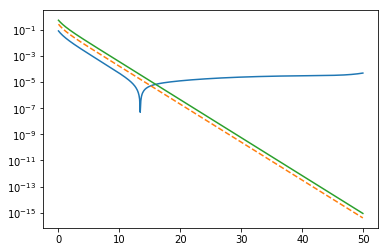

0 500 0.6695198210670671
0.0 [ 5.84643518e-06 -1.11749812e-04]


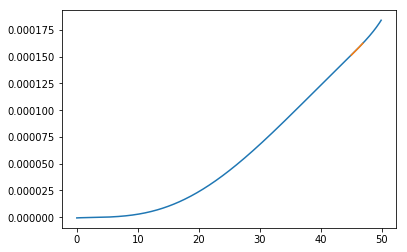

0.6695198210670671
0.5683299590219636


In [17]:
#plt.plot(vrange2,np.abs(massnp[uval]))
plt.plot(vrange2,np.abs(drnpv[uval]))
plt.plot(vrange2,np.abs(drnpu[uval]),'--')
plt.plot(vrange2,np.abs(np.exp(signp[uval])))
#plt.ylim(massnp[uval,-1]-.00000000001,massnp[uval,-1]+.00000000001)
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(100,300)
plt.show()
print(0,Nv,kappaminus)
v1=Nv-50
v2=Nv-30
print(0.0,np.polyfit(vrange2[v1:v2],np.log(np.abs(massnp[uval][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(massnp[uval])))
plt.plot(vrange2[v1:v2],np.log(np.abs(massnp[uval][v1:v2])))
plt.show()

print(kappaminus)
print(kappaminus-2*kappacosm)

In [ ]:
for i in range(int(Nu/100)):
    i2=100*i
    plt.plot(vrange,np.log(np.abs(np.exp(-signp[i2])*drnpv[i2])))#*drnpv[i2])))
plt.show()


In [ ]:
print(Nv)
uval2=uval
v1=Nv-200
v2=Nv-100
print(np.polyfit(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])),1.0))
plt.plot(vrange2,np.log(np.abs(np.exp(-signp[uval2])*drnpv[uval2])))
plt.plot(vrange2[v1:v2],np.log(np.abs(np.exp(-signp[uval2][v1:v2])*drnpv[uval2][v1:v2])))
plt.show()

print(kappaminus,kappaminus-2*kappacosm,kappaminus-2*kappaplus)

In [ ]:
print(massnp[0,-1])

In [ ]:
rnp2=rnp[0,-100]+10**(-15)*np.random.random(Nv)

dsignpv3=2*((massnp[0,-100]*rnp2-Q**2-1/3*Lambda*rnp2**4)/(rnp2**3-2*massnp[0,-100]*rnp2**2+Q**2*rnp2-Lambda/3*rnp2**5))*drnpv[0]
plt.plot(vrange,dsignpv3)
#plt.ylim(-1,1)
plt.show()
#print(dsignpv2)

In [ ]:
dsignpv2=2*((massnp[0,0]*rnp[0]-Q**2-1/3*Lambda*rnp[0]**4)/(rnp[0]**3-2*massnp[0,0]*rnp[0]**2+Q**2*rnp[0]-Lambda/3*rnp[0]**5))*drnpv[0]
plt.plot(vrange,dsignpv2)
plt.show()
print(dsignpv2)

In [ ]:
massnp2=massnp[0,-1]+10**(-19)*np.random.random(Nv)

dsignpv2=2*((massnp2*rnp[0,-1]-Q**2-1/3*Lambda*rnp[0,-1]**4)/(rnp[0,-1]**3-2*massnp2*rnp[0,-1]**2+Q**2*rnp[0,-1]-Lambda/3*rnp[0,-1]**5))*drnpv[0]
plt.plot(vrange,dsignpv2)
#plt.ylim(-.12,-.09)
plt.show()
print(dsignpv2)

In [ ]:
Rfunc=-drnpv[uval]*drnpu[uval]/rnp[uval]-np.exp(signp[uval])/(4.0*rnp[uval])*(1.0-np.power((Q/rnp[uval]),2.0)-Lambda*np.power(rnp[uval],2.0))

In [ ]:
print(0.0,Nu)
numlines=10
for i in range(numlines):
    i=int(i*Nu/numlines)
    Rfunc=-drnpv[i]*drnpu[i]/rnp[i]-np.exp(signp[i])/(4.0*rnp[i])*(1.0-np.power((Q/rnp[i]),2.0)-Lambda*np.power(rnp[i],2.0))
    #plt.plot(vrange2,Rfunc/dercorr)
    plt.plot(vrange2,np.abs(Rfunc)/dercorr,'--')
    #plt.plot(vrange2[0:Nv-1],np.abs(np.diff(rnp[uval])/np.diff(vrange2)))
plt.yscale('log')
plt.grid()
plt.show()
#plt.plot(vrange2,Rfunc)
#plt.plot(vrange2,np.abs(Rfunc),'--')
#plt.yscale('log')
#plt.show()

In [ ]:
r2=1.56
print(1-Q**2.0/r2**2.0-Lambda*r2**2.0)

In [ ]:
print(np.nanmin(massnp[:,0]),np.nanmax(massnp[:,0]))

In [ ]:
plt.plot(urange,massnp[:,0])
plt.plot(urange,massnp[:,1])
plt.plot(urange,massnp[:,-1])
#plt.yscale('log')
plt.grid()
plt.show()
print(massnp)

plt.plot(vrange2,massnp[0])
plt.plot(vrange2,massnp[1])
plt.plot(vrange2,massnp[-1])
#plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
plt.plot(vrange2,np.abs(drnpv[uval]))
plt.show()

In [ ]:
print(len(rnp),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnp))
rnpf=np.delete(rnp,-1,axis=0)
massnpf=np.delete(massnp,-1,axis=0)
print(len(rnpf),len(drnpv),len(drnpu),len(dphinpv),len(dphinpu),len(massnpf))
Curvature=odeu.Kretsch(rnp,drnpv,drnpu,dphinpv,dphinpu,massnp,Q,Lambda)


In [ ]:
#plt.plot(vrange2,Curvature[30])
#plt.show()
Nuf=int(Nu*9/10)

print(0.0,Nuf)
numlines=30
for i in range(numlines):
    i=int(i*Nuf/numlines)
   
    plt.plot(vrange2,Curvature[i],'--')
plt.xlabel(r'$v$')
plt.ylabel(r'$K$')
plt.yscale('log')
plt.grid()
plt.title('Kretschman scalar')
#plt.savefig('num-rel-pics/K vs v.png',dpi=300)
plt.show()

In [ ]:
print(rminus)
odeu.Kretsch(rminus,1,1,0,0,M0,Q,Lambda)

In [ ]:
plt.plot(rnp[uval],phinp[uval])
#plt.ylim(0,.0001)
#plt.xlim(min(rnp[uval])+.1,1)
plt.yscale('log')
plt.xlim(.1,2)
plt.xscale('log')
plt.show()

In [ ]:
plt.plot(vrange2,np.abs(phinp[uval])/dercorr,label=r'$\Phi$')
#plt.xlim(0,2)

In [ ]:
print(drnpv[0])

In [ ]:
print(signp)